In [8]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
plt.style.use('dark_background')

# Load Dataset

In [9]:
xr_train = np.load('dataset/xr_train.npy').astype(np.float32)
yr_train = np.load('dataset/yr_train.npy').astype(np.float32)
xr_val = np.load('dataset/xr_val.npy').astype(np.float32)
yr_val = np.load('dataset/yr_val.npy').astype(np.float32)
xl_train = np.load('dataset/xl_train.npy').astype(np.float32)
yl_train = np.load('dataset/yl_train.npy').astype(np.float32)
xl_val = np.load('dataset/xl_val.npy').astype(np.float32)
yl_val = np.load('dataset/yl_val.npy').astype(np.float32)

print(xr_train.shape, yr_train.shape)
print(xr_val.shape, yr_val.shape)
print(xl_train.shape, yl_train.shape)
print(xl_val.shape, yl_val.shape)

(43, 34, 26, 1) (43, 1)
(11, 34, 26, 1) (11, 1)
(44, 34, 26, 1) (44, 1)
(11, 34, 26, 1) (11, 1)


In [10]:
IMG_HEIGHT = 26
IMG_WIDTH = 34

# Preview

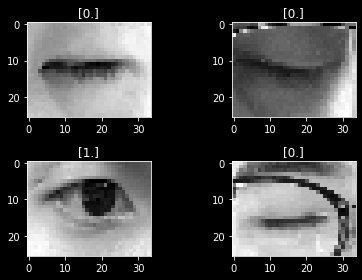

In [11]:
plt.subplot(2, 2, 1)
plt.title(str(yr_train[0]))
plt.imshow(xr_train[0].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
plt.subplot(2, 2, 2)
plt.title(str(yr_val[4]))
plt.imshow(xr_val[4].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
plt.subplot(2, 2, 3)
plt.title(str(yl_train[0]))
plt.imshow(xl_train[0].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
plt.subplot(2, 2, 4)
plt.title(str(yl_val[4]))
plt.imshow(xl_val[4].reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
plt.tight_layout()

# Data Augmentation

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

r_train_generator = train_datagen.flow(
    x=xr_train, y=yr_train,
    batch_size=32,
    shuffle=True
)

l_train_generator = train_datagen.flow(
    x=xl_train, y=yl_train,
    batch_size=32,
    shuffle=True
)

r_val_generator = val_datagen.flow(
    x=xr_val, y=yr_val,
    batch_size=32,
    shuffle=False
)

l_val_generator = val_datagen.flow(
    x=xl_val, y=yl_val,
    batch_size=32,
    shuffle=False
)

# Build Model

In [14]:
inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1))

net = Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(512)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('sigmoid')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 34, 26, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 17, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 3, 128)         0   

# Train

In [15]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    r_train_generator, epochs=50, validation_data=r_val_generator,
    callbacks=[
        ModelCheckpoint('models/%sr.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

model.fit_generator(
    l_train_generator, epochs=50, validation_data=l_val_generator,
    callbacks=[
        ModelCheckpoint('models/%sl.h5' % (start_time), monitor='val_acc', save_best_only=True, mode='max', verbose=1),
        ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
    ]
)

Epoch 1/50
2/2 [==============================] - 0s 235ms/step - loss: 0.6802 - acc: 0.5349 - val_loss: 0.8476 - val_acc: 0.4545

Epoch 00001: val_acc improved from -inf to 0.45455, saving model to models/2020_05_22_22_53_22r.h5
Epoch 2/50
2/2 [==============================] - 0s 32ms/step - loss: 0.7693 - acc: 0.5349 - val_loss: 0.7114 - val_acc: 0.4545

Epoch 00002: val_acc did not improve from 0.45455
Epoch 3/50
2/2 [==============================] - 0s 32ms/step - loss: 0.6969 - acc: 0.5349 - val_loss: 0.6925 - val_acc: 0.5455

Epoch 00003: val_acc improved from 0.45455 to 0.54545, saving model to models/2020_05_22_22_53_22r.h5
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.6954 - acc: 0.4651 - val_loss: 0.6918 - val_acc: 0.5455

Epoch 00004: val_acc did not improve from 0.54545
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6939 - acc: 0.4651 - val_loss: 0.6946 - val_acc: 0.4545

Epoch 00005: val_acc did not improve from 0.5454


Epoch 00044: val_acc did not improve from 0.54545
Epoch 45/50
2/2 [==============================] - 0s 26ms/step - loss: 0.6838 - acc: 0.5349 - val_loss: 0.7014 - val_acc: 0.4545

Epoch 00045: val_acc did not improve from 0.54545
Epoch 46/50
2/2 [==============================] - 0s 30ms/step - loss: 0.6855 - acc: 0.5349 - val_loss: 0.7014 - val_acc: 0.4545

Epoch 00046: val_acc did not improve from 0.54545
Epoch 47/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6876 - acc: 0.5349 - val_loss: 0.7013 - val_acc: 0.4545

Epoch 00047: val_acc did not improve from 0.54545
Epoch 48/50
2/2 [==============================] - 0s 28ms/step - loss: 0.6845 - acc: 0.5349 - val_loss: 0.7013 - val_acc: 0.4545

Epoch 00048: val_acc did not improve from 0.54545
Epoch 49/50
2/2 [==============================] - 0s 28ms/step - loss: 0.6800 - acc: 0.5349 - val_loss: 0.7012 - val_acc: 0.4545

Epoch 00049: val_acc did not improve from 0.54545
Epoch 50/50
2/2 [===========================

Epoch 40/50
2/2 [==============================] - 0s 28ms/step - loss: 0.6789 - acc: 0.5682 - val_loss: 0.7271 - val_acc: 0.3636

Epoch 00040: val_acc did not improve from 0.36364
Epoch 41/50
2/2 [==============================] - 0s 27ms/step - loss: 0.6884 - acc: 0.5682 - val_loss: 0.7272 - val_acc: 0.3636

Epoch 00041: val_acc did not improve from 0.36364
Epoch 42/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6697 - acc: 0.5682 - val_loss: 0.7274 - val_acc: 0.3636

Epoch 00042: val_acc did not improve from 0.36364
Epoch 43/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6653 - acc: 0.5682 - val_loss: 0.7277 - val_acc: 0.3636

Epoch 00043: val_acc did not improve from 0.36364
Epoch 44/50
2/2 [==============================] - 0s 27ms/step - loss: 0.6715 - acc: 0.5682 - val_loss: 0.7281 - val_acc: 0.3636

Epoch 00044: val_acc did not improve from 0.36364
Epoch 45/50
2/2 [==============================] - 0s 29ms/step - loss: 0.6762 - acc: 0.5682 - 

# Confusion Matrix

test acc: 0.5454545454545454


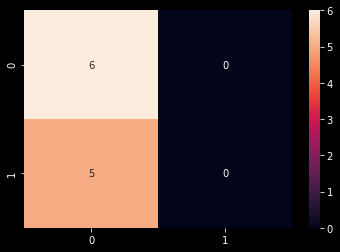

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

model = load_model('models/%sr.h5' % (start_time))

yr_pred = model.predict(xr_val/255.)
yr_pred_logical = (yr_pred > 0.7).astype(np.int)

print ('test acc: %s' % accuracy_score(yr_val, yr_pred_logical))
cm = confusion_matrix(yr_val, yr_pred_logical)
sns.heatmap(cm, annot=True)

# Distribution of Prediction

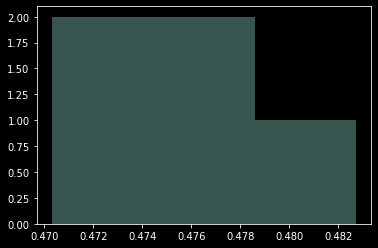

In [15]:
ax = sns.distplot(yr_pred, kde=False)